In [5]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import opendssdirect as dss
from utils import spectral_analysis,make_deviations,make_S_0,make_S_tilde,make_sens_ts
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens
import opendssdirect as dss
imp.reload(mat_sens)

<module 'matrix_sensitivities' from '/home/sam/github/PowerSensitivities.jl/py/matrix_sensitivities.py'>

In [6]:
sns.set_context("paper")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 1

# Case 1: Constant 0.9 Nonunity Power Factor
## Data Management

### Make basic constant power factor data for IEEE 123

In [183]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
svp,svq = sens['svp'],sens['svq']

print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (190, 23) (95, 23)


### Find the relevant controllable PQ buses 

- Find all buses with 0.9 fixed power factor (loads)
- Make truncated $\tilde{S}$ matrix 
- Make truncated training data $\Delta X, \Delta V$
- Make truncated implicit $Q-P$ representation matrix $K$

In [184]:
#Find the buses with loads (controlled buses where 0.9 power factor holds)
pf = np.cos(np.arctan(np.divide(q,p)))
study_bus = [] #Controlled buses
for bus_i,pf_i in enumerate(pf):
    if np.isclose(np.mean(pf_i),0.9):
        study_bus.append(bus_i)

/tmp/ipykernel_6916/2676379099.py:2: RuntimeWarning: invalid value encountered in true_divide
  pf = np.cos(np.arctan(np.divide(q,p)))


In [185]:
#Make truncated sensitivities matrices for the studied buses 
svp0 = [svp_t[np.ix_(study_bus,study_bus)] for svp_t in svp]
svq0 = [svq_t[np.ix_(study_bus,study_bus)] for svq_t in svq]
S_tilde = [make_S_tilde(svp0_t,svq0_t) for svp0_t,svq0_t in zip(svp0,svq0)]

# Make implicit representation for the studied buses
imp.reload(mat_sens)
pf = 0.9*np.ones(svp0[0].shape[0])
K = mat_sens.K(pf)
svq_impl = [svq0_t@K for svq0_t in svq0]


#Make truncated training data
p0,q0,v0 = p[np.ix_(study_bus)],q[np.ix_(study_bus)],v[np.ix_(study_bus)] #Truncated measurement data
diff = make_deviations((p0,q0,v0)) #Deviations
(dx,dv) = diff #multivariate time series estimation


#Print shapes
print("stilde, svp,svq shapes: ",S_tilde[0].shape,svp0[0].shape,svq0[0].shape)
print("K,svq_impl shapes: ",K.shape,svq_impl[0].shape)
print("Data shapes: ",p0.shape,q0.shape,v0.shape)
print("Diff shapes: ",dx.shape,dv.shape)

stilde, svp,svq shapes:  (95, 190) (95, 95) (95, 95)
K,svq_impl shapes:  (95, 95) (95, 95)
Data shapes:  (95, 24) (95, 24) (95, 24)
Diff shapes:  (190, 23) (95, 23)


## Perform the Implicit P-Q estimation with varying noise levels

In [186]:
def make_deviations(data,sigma=0):
    """
    Make finite difference data with noise level sigma
    """
    p,q,v = data
    (dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
    dx = np.vstack((dp,dq)) 
    return (
        dx + np.random.normal(0,sigma,size=dx.shape),
        dv + np.random.normal(0,sigma,size=dv.shape)
        )

In [315]:
#noise values
sigma = np.sqrt(abs(np.mean(dx))*(0.1/100)) #Assume 0.1 pct. error of the AMI sensor for uncertainty quantitification per NIST.
noise_seeds = np.arange(2022,2052) #Seeds for resampling noise levels

#Make Sdagger matrix
S_dag = [(svp0_t + svq_impl_t) for svp0_t,svq_impl_t in zip(svp0,svq_impl)]
n,_ = S_dag[0].shape

#Results dictionaries
results_dicts = []
wide_results_dicts =[]

#Results matrices
results_matrices = []

for seed in noise_seeds:

    np.random.seed(seed)
    #Make deviations at the noise level
    diff = make_deviations((p0,q0,v0),sigma=sigma) #Deviations
    (dx,dv) = diff #multivariate time series estimation


    #Get true dp and dq
    dp,dq = dx[:n,:],dx[n:,:]

    #Make results matrix for dp and dq
    dp_hat,dq_hat = np.zeros_like(dp),np.zeros_like(dq)

    #Estimate dp and dq
    for t,(S_dag_t,dv_t) in enumerate(zip(S_dag,dv.T)):
        dp_hat[:,t] = np.linalg.inv(S_dag_t)@dv_t #Compute the active power estimate
        dq_hat[:,t] = K@dp_hat[:,t] #Compute the reactive power estimate

        #Save each estimate at each node as a dictionary for plotting
        for i,(dp_hat_i_t,dq_hat_i_t) in enumerate(zip(dp_hat[:,t],dq_hat[:,t])):
            #Collect injections, injection estimates, and injection types
            types,injs,inj_ests = ['P','Q'],[dp[i,t],dq[i,t]],[dp_hat_i_t,dq_hat_i_t]
            for type_inj,inj,inj_est in zip(types,injs,inj_ests):
                results_dicts.append( #Save results for the true injection
                    {
                        "time":t,
                        "node":i,
                        "inj":inj,
                        "series":r"$(\Delta p,\Delta q)$",
                        "type":type_inj,
                        "sigma":sigma
                    }
                )
                results_dicts.append( #Save estimated injection
                    {
                        "time":t,
                        "node":i,
                        "inj":inj_est,
                        "series":r"$(\Delta \hat{p},\Delta \hat{q})$",
                        "type":type_inj,
                        "sigma":sigma
                    }
                )
                wide_results_dicts.append(
                    {
                        "time":t,
                        "node":i,
                        "dp_hat":dp_hat_i_t,
                        "dq_hat":dq_hat_i_t,
                        "dp":dp[i,t],
                        "dq":dq[i,t],
                        "sigma":sigma
                    }
                )
    #Save the results matrices for this noise level
    results_matrices.append(
        {
            'sigma':sigma,
            'dp_hat':dp_hat,
            'dq_hat':dq_hat
        }
    )

#Make a dataframe from the results dictionaries
results_df = pd.DataFrame.from_dict(results_dicts)
wide_results_df = pd.DataFrame.from_dict(wide_results_dicts)

In [316]:
#Setup plot variables
n_plots = 20
plot_width = 7.16 #inches
plot_height = 7.16/1.61828 #plot height

n_rows = 4
n_cols = 5
facet_height = plot_height/n_rows
facet_width = plot_width/n_cols

aspect = facet_width/facet_height #facet_width = aspect*facet_height
aspect

1.2946239999999998

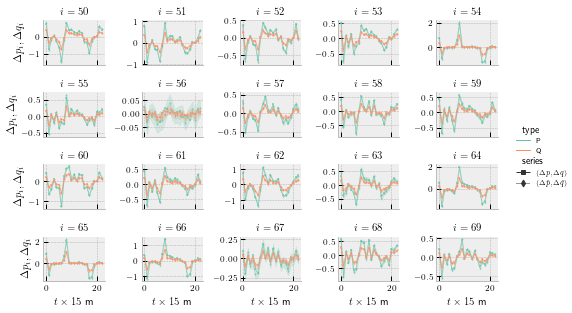

In [326]:
#Plot the estimation
g = sns.relplot(
    data=results_df[results_df["node"].between(50,69)],
    x="time",
    y="inj",
    col="node",
    col_wrap=5,
    kind='line',
    hue='type',
    style='series',
    palette='Set2',#[cmap.get_under(),cmap.get_over()],
    aspect=aspect,
    height=facet_height,
    facet_kws={
        "sharex":True,
        "sharey":False,
    },
    alpha=0.65,
    lw=0.5,
    markers=['s','d'],
    dashes=[(2,0),(1,1)],
    ms=2.5,
    mew=0.1
)
g.set_titles(r"$i={col_name}$")
g.set_ylabels(r"$\Delta p_i,\Delta q_i$")
g.set_xlabels(r"$t \times 15$ m")
g.tight_layout()
g.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/impl_est_results.pdf",dpi=300)

In [327]:
v.shape

(274, 24)

'/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF'

## Plot Results

In [ ]:

#Plot results
fig,axes = plt.subplots(nrows=2,ncols=2)


#Plot real power estimate
plt.plot(dp_hat[:,0],'o')
plt.plot(dp[:,0],'o')
plt.title("$\Delta \hat{p}_t$")

#Plot active power estimate
plt.figure()
plt.plot(dq_hat[:,0],'o')
plt.plot(dq[:,0],'o')
plt.title("$\Delta \hat{q}_t$")


In [460]:
dp,dq = dx[:int(len(dx)/2),:],dx[int(len(dx)/2):,:]
K_est = np.zeros_like(K)
for i,(dp_i,dq_i) in enumerate(zip(dp.T,dq.T)):
    DP = np.vstack((dp_i.T,np.ones_like(dp_i).T)).T
    lsq = np.linalg.inv(DP.T@DP)@DP.T@dq_i
    K_est[i,i] = lsq[0]

### Implicit Matrix Recovery Problem

In [ ]:
imp.reload(mat_sens)
lambd_,delta1_,delta2_ = cp.Parameter(),cp.Parameter(),cp.Parameter()
lamb_.value,delta1_.value,delta2_.value = 1.25e-1,6e-2,8e-2
prob = mat_sens.mat_rec_problem_implicit(

In [458]:
print("Relative pct. error of the 'true' sensitivity matrix: ",np.linalg.norm(dv[:,0] - S_tilde@dx[:,0])/np.linalg.norm(dv[:,0])*100)

Relative pct. error of the 'true' sensitivity matrix:  1.1973718447073551


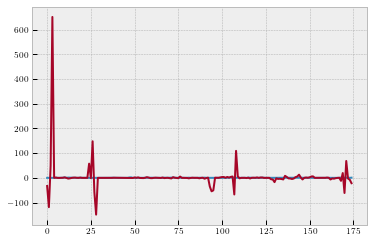

In [459]:
plt.plot(dp[:,0][25:200])
plt.plot((np.linalg.inv(svp[0])@dv[:,0])[25:200])

In [466]:
impl_err = []
hat_dq = np.zeros_like(dq)
for t,(dx_t,dv_t,svq_t,svp_t,q_t) in enumerate(zip(dx.T,dv.T,svq,svp,q.T)):
    #Split out dp_t and dq_t
    dp_t,dq_t = dx_t[:int(len(dx_t)/2)],dx_t[int(len(dx_t)/2):]
    #get signs of reactive power
    #sign_q = np.diag(np.sign(q_t))
    #svq_impl_t = svq_t @ (np.multiply(K,-sign_q))
    svq_impl_t = svq_t @K
    #make S_dagger
    S_dag = svp_t + svq_impl_t
    #Estimate dv_t,dp_t,dq_t
    hat_dv_t = S_dag@dp_t
    hat_dp_t = np.linalg.inv(svp_t)@dv_t
    hat_dq_t = (np.multiply(K,-sign_q))@dp_t
    hat_dq[:,t] = hat_dq_t
    #Construct hat_dx_t
    hat_dx_t = np.concatenate((hat_dp_t,hat_dq_t))
    impl_err.append({
        'dv_rel_err':utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100,
        'dp_rel_err':utils.calc_vector_rel_err(v_est=hat_dp_t,v_true=dp_t)*100,
        'dq_rel_err':utils.calc_vector_rel_err(v_est=hat_dq_t,v_true=dq_t)*100,
        'dx_rel_err':utils.calc_vector_rel_err(v_est=hat_dx_t,v_true=dx_t)*100
    })

import pandas as pd
df = pd.DataFrame.from_dict(impl_err)